In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np

## Distributing the data

Distributing the data into 5 different clients

In [5]:
def create_federated_data(source_folder, num_clients=5, output_folder="federated data"):
    if not os.path.exists(source_folder):
        print(f"Source folder '{source_folder}' does not exist.")
        return
    
    # Create output folder
    os.makedirs(output_folder, exist_ok=True)
    
    # Get class subfolders
    class_folders = [d for d in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, d))]
    
    # Create client directories
    for client_id in range(1, num_clients + 1):
        client_path = os.path.join(output_folder, f"client_{client_id}")
        os.makedirs(client_path, exist_ok=True)
        for class_name in class_folders:
            os.makedirs(os.path.join(client_path, class_name), exist_ok=True)
    
    # Distribute images
    for class_name in class_folders:
        class_path = os.path.join(source_folder, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)  # Shuffle images for randomness
        
        # Split images across clients
        for idx, image in enumerate(images):
            client_id = (idx % num_clients) + 1  # Distribute evenly
            src = os.path.join(class_path, image)
            dst = os.path.join(output_folder, f"client_{client_id}", class_name, image)
            shutil.copy2(src, dst)
    
    print(f"Data successfully distributed among {num_clients} clients in '{output_folder}' folder.")

create_federated_data("processed data", num_clients=5, output_folder="federated data")

Data successfully distributed among 5 clients in 'federated data' folder.


Splitting the data fro each client into train(70%), test(15%) and validation(15%) sets

In [7]:
def split_client_data(client_folder, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(client_folder):
        print(f"Client folder '{client_folder}' does not exist.")
        return
    
    # Paths for train, val, and test sets
    split_folders = ["train", "val", "test"]
    for split in split_folders:
        os.makedirs(os.path.join(client_folder, split), exist_ok=True)
    
    # Get only the actual class folders (excluding train, val, test)
    class_folders = [d for d in os.listdir(client_folder) 
                     if os.path.isdir(os.path.join(client_folder, d)) and d not in split_folders]
    
    for class_name in class_folders:
        class_path = os.path.join(client_folder, class_name)
        images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        
        if not images:
            continue  # Skip empty classes
        
        random.shuffle(images)
        
        num_images = len(images)
        train_end = max(int(num_images * train_ratio), 1)  # Ensure at least one image in train
        val_end = max(train_end + int(num_images * val_ratio), train_end + 1)  # Ensure at least one in val
        
        # Ensure that at least one image is left for test if possible
        if num_images - val_end == 0 and val_end > train_end:
            val_end -= 1  # Adjust to keep at least one for test
        
        splits = {
            "train": images[:train_end],
            "val": images[train_end:val_end],
            "test": images[val_end:] if val_end < num_images else images[train_end:]  # Ensure test set is not empty
        }
        
        for split, split_images in splits.items():
            split_path = os.path.join(client_folder, split, class_name)
            os.makedirs(split_path, exist_ok=True)  # Create correct class directory inside split
            for image in split_images:
                shutil.move(os.path.join(class_path, image), os.path.join(split_path, image))
        
        # Remove the empty class folder after moving files
        shutil.rmtree(class_path, ignore_errors=True)

# Apply split to all clients
clients_folder = "federated data"
for client in os.listdir(clients_folder):
    client_path = os.path.join(clients_folder, client)
    if os.path.isdir(client_path):
        split_client_data(client_path)

print("Data successfully split into train, val, and test sets for each client.")

Data successfully split into train, val, and test sets for each client.


Distribution of data into train, test and val sets for each client

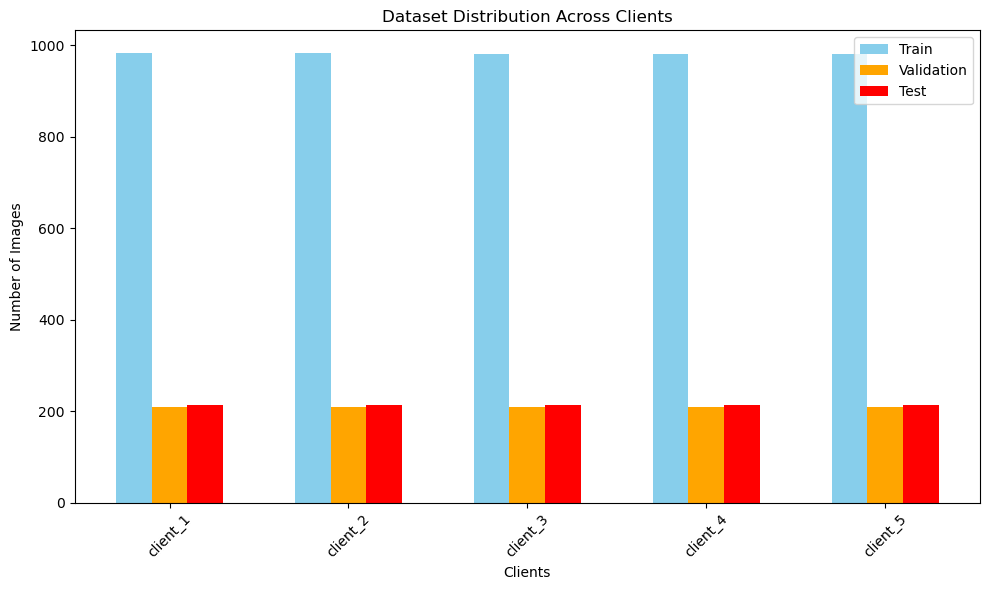

In [4]:
def count_images_in_split(client_folder):
    split_counts = {"train": 0, "val": 0, "test": 0}
    
    for split in split_counts.keys():
        split_path = os.path.join(client_folder, split)
        if os.path.exists(split_path):
            split_counts[split] = sum(len(files) for _, _, files in os.walk(split_path))
    
    return split_counts

def plot_client_data_distribution(clients_folder):
    clients = [d for d in os.listdir(clients_folder) if os.path.isdir(os.path.join(clients_folder, d))]
    train_counts, val_counts, test_counts = [], [], []
    
    for client in clients:
        client_path = os.path.join(clients_folder, client)
        counts = count_images_in_split(client_path)
        train_counts.append(counts["train"])
        val_counts.append(counts["val"])
        test_counts.append(counts["test"])
    
    x = np.arange(len(clients))
    width = 0.2  # Bar width
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, train_counts, width, label='Train', color='skyblue')
    ax.bar(x, val_counts, width, label='Validation', color='orange')
    ax.bar(x + width, test_counts, width, label='Test', color='red')
    
    ax.set_xlabel("Clients")
    ax.set_ylabel("Number of Images")
    ax.set_title("Dataset Distribution Across Clients")
    ax.set_xticks(x)
    ax.set_xticklabels(clients, rotation=45)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_client_data_distribution("federated data")